In [1]:
import sys, os
import igraph as ig
import xsimlab as xs
import numpy as np
import pandas as pd

sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.architectural_development import architectural_development as model

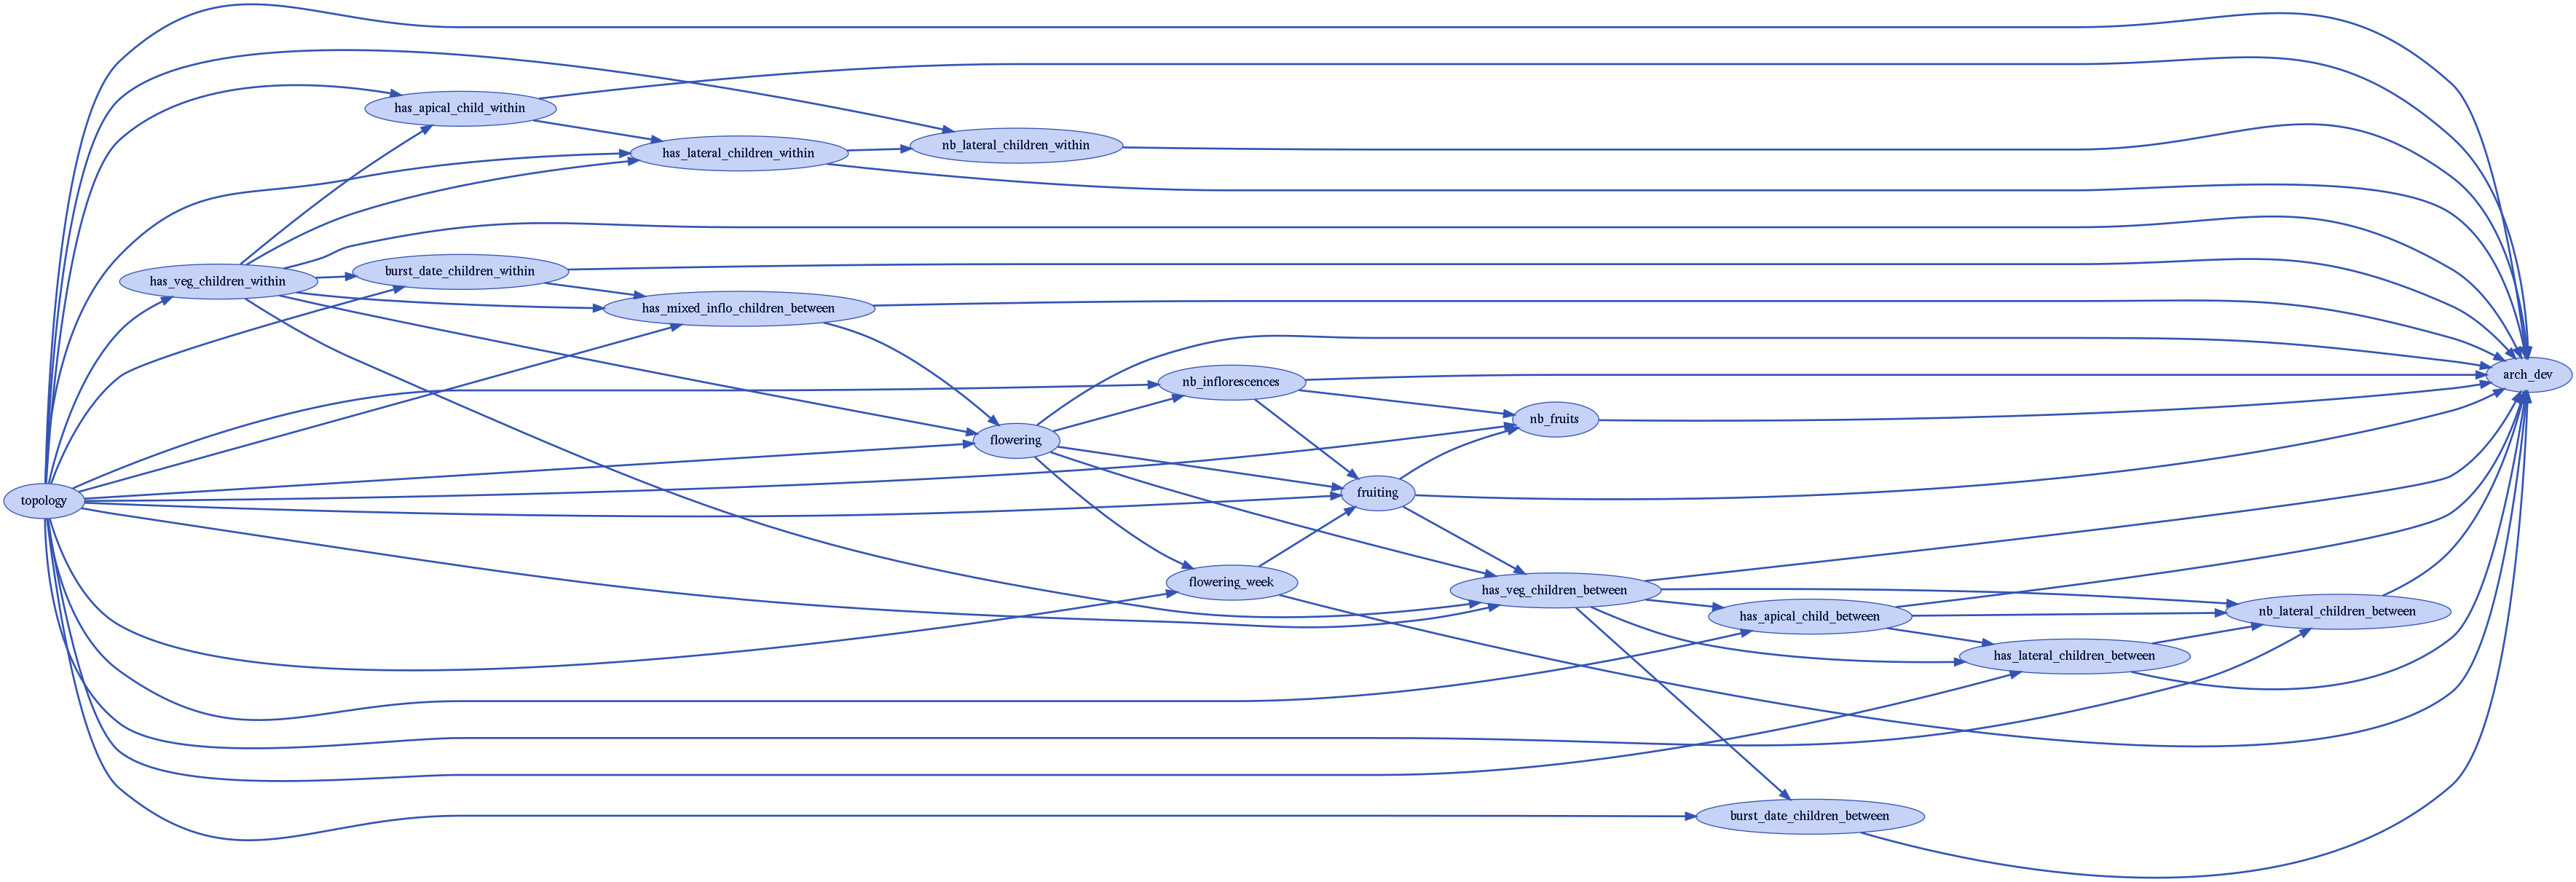

In [2]:
model.visualize(show_variables=False)

In [3]:
# just a monthly timestep at 1st of month
from vmlab.enums import Nature
clock = pd.date_range(start='2003-02-01', end='2007-09-01', freq="MS")
ds = vmlab.create_setup(
    model=model,
    setup_toml='../share/setup/architectural_development_model.toml',
    clocks={
        'month': clock
    },
    input_vars={
        'topology': {
            'seed': 100,
            'current_cycle': 3,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214,
            'appearance_date': np.array(['2003-01-01'], dtype='datetime64[D]'),
        },
        'arch_dev': {
            'burst_date': np.array(['2003-03-01'], dtype='datetime64[D]'),
            'has_apical_child': np.array([1.]),
            'nb_lateral_children': np.array([0.]),
            'nature': np.array([Nature.VEGETATIVE])
        },
        'flowering_week': {
            'flowering_date': np.array([np.datetime64('NAT')], dtype='datetime64[D]')
        }
    }
)

In [4]:
ds_out = ds.xsimlab.run(model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar()])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                                             (GU: 23, month: 56)
Coordinates:
  * GU                                                                  (GU) <U4 ...
  * month                                                               (month) datetime64[ns] ...
Data variables:
    arch_dev__burst_date                                                (GU) datetime64[D] ...
    arch_dev__has_apical_child                                          (GU) float64 ...
    arch_dev__nature                                                    (GU) float64 ...
    arch_dev__nb_lateral_children                                       (GU) float64 ...
    burst_date_children_between__burst_date_children_between            (GU) datetime64[D] ...
    burst_date_children_between__table_dir_path                         <U80 ...
    burst_date_children_within__burst_date_children_within              (GU) datetime64[D] ...
    burst_date_children_within__burst_month_within                      (GU) int64 ...
    burst_date_children_within__table_dir_path                          <U79 ...
    flowering__flowering                                                (GU) float64 ...
    flowering__table_dir_path                                           <U62 ...
    flowering_week__flowering_date                                      (GU) datetime64[D] ...
    flowering_week__flowering_week                                      (GU) float64 ...
    flowering_week__table_dir_path                                      <U67 ...
    fruiting__fruiting                                                  (GU) float64 ...
    fruiting__table_dir_path                                            <U61 ...
    has_apical_child_between__has_apical_child_between                  (GU) float64 ...
    has_apical_child_between__table_dir_path                            <U77 ...
    has_apical_child_within__has_apical_child_within                    (GU) float64 ...
    has_apical_child_within__table_dir_path                             <U76 ...
    has_lateral_children_between__has_lateral_children_between          (GU) float64 ...
    has_lateral_children_between__table_dir_path                        <U81 ...
    has_lateral_children_within__has_lateral_children_within            (GU) float64 ...
    has_lateral_children_within__table_dir_path                         <U80 ...
    has_mixed_inflo_children_between__has_mixed_inflo_children_between  (GU) float64 ...
    has_mixed_inflo_children_between__table_dir_path                    <U85 ...
    has_veg_children_between__has_veg_children_between                  (GU) float64 ...
    has_veg_children_between__nature                                    (GU) float64 ...
    has_veg_children_between__table_dir_path                            <U77 ...
    has_veg_children_within__has_veg_children_within                    (GU) float64 ...
    has_veg_children_within__table_dir_path                             <U76 ...
    nb_fruits__nb_fruits                                                (GU) float64 ...
    nb_fruits__table_dir_path                                           <U62 ...
    nb_inflorescences__nb_inflorescences                                (GU) float64 ...
    nb_inflorescences__table_dir_path                                   <U70 ...
    nb_lateral_children_between__nb_lateral_children_between            (GU) float64 ...
    nb_lateral_children_between__table_dir_path                         <U80 ...
    nb_lateral_children_within__nb_lateral_children_within              (GU) float64 ...
    nb_lateral_children_within__table_dir_path                          <U79 ...
    topology__adjacency                                                 (GU, GU) float64 ...
    topology__ancestor                                                  (GU) int64 ...
    topology__ancestor_is_apical                                        (GU) float64 ...
    topology__ancestor_nature               

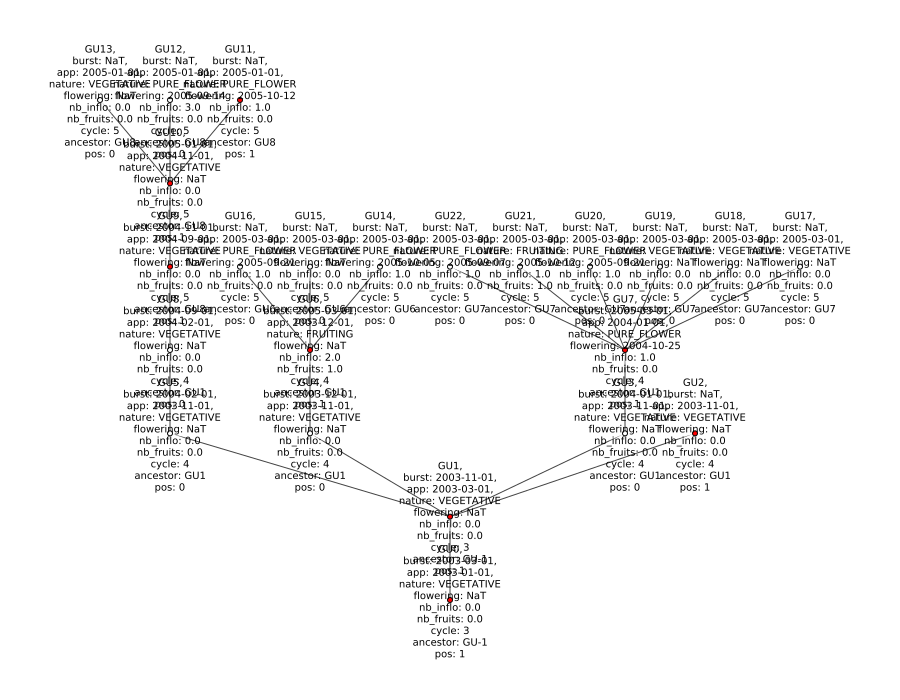

In [5]:
Nature_Names = {v: k for k, v in Nature.items()}
g = ig.Graph.Adjacency(list(ds_out.topology__adjacency.data))
layout = g.layout_reingold_tilford(root=0)
layout.rotate(-180)
ig.plot(g, layout=layout, bbox=(900, 700), margin=(100, 100, 100, 100), **{
    'vertex_size': 5,
    'vertex_label_size': 10,
    'edge_arrow_width': 0.1,
    'vertex_color': ['red' if is_apical else 'white' for is_apical in ds_out.topology__position.data],
    'vertex_label': [
        f'GU{idx}, \
        \nburst: {ds_out.arch_dev__burst_date.data[idx]}, \
        \napp: {ds_out.topology__appearance_date.data[idx].item().isoformat()}, \
        \nnature: {Nature_Names[ds_out.arch_dev__nature.data[idx]]} \
        \nflowering: {ds_out.flowering_week__flowering_date.data[idx]} \
        \nnb_inflo: {ds_out.nb_inflorescences__nb_inflorescences.data[idx]} \
        \nnb_fruits: {ds_out.nb_fruits__nb_fruits.data[idx]} \
        \ncycle: {int(ds_out.topology__cycle.data[idx])} \
        \nancestor: GU{int(ds_out.topology__ancestor.data[idx])} \
        \npos: {int(ds_out.topology__position.data[idx])}' \
        for idx in g.vs.indices
    ]
})